In [1]:
import yfinance as yf
import numpy as np
#import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import pyspark.pandas as pd

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\Satyam\AppData\Roaming\Python\Python310\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
# Step 1: Fetch stock data using yfinance
stock_symbol = '^NSEI'
start_date = '2001-01-01'
end_date = '2023-08-27'
data = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0


# Closing Price Plot

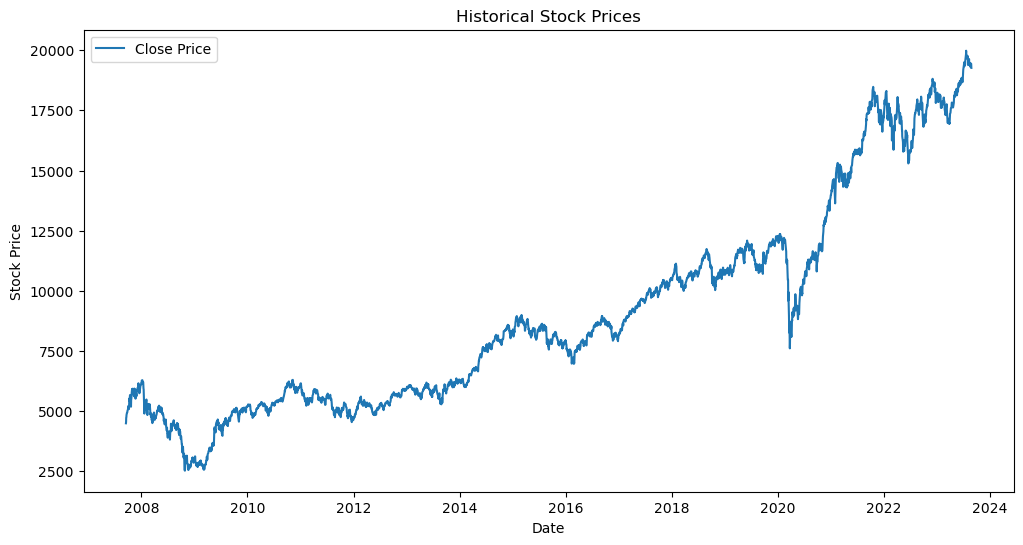

In [4]:
# Visualize historical prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Historical Stock Prices')
plt.legend()
plt.show()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3908 entries, 2007-09-17 to 2023-08-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3908 non-null   float64
 1   High       3908 non-null   float64
 2   Low        3908 non-null   float64
 3   Close      3908 non-null   float64
 4   Adj Close  3908 non-null   float64
 5   Volume     3908 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 213.7 KB


In [6]:
# Checking Null Values
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Adding more derived columns for better result

In [7]:
# Add derived columns like moving averages (EMA)
data['EMA_5'] = data['Close'].rolling(window=5).mean()
data['EMA_10'] = data['Close'].rolling(window=10).mean()
data['EMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_50'] = data['Close'].rolling(window=50).mean()
data['EMA_100'] = data['Close'].rolling(window=100).mean()
data['EMA_200'] = data['Close'].rolling(window=200).mean()

In [8]:
data.shape

(3908, 12)

In [9]:
# Checking Null Values
data.isna().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
EMA_5          4
EMA_10         9
EMA_20        19
EMA_50        49
EMA_100       99
EMA_200      199
dtype: int64

In [10]:
#Drop Values With Null Values
data.dropna(inplace=True)

In [11]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume,EMA_5,EMA_10,EMA_20,EMA_50,EMA_100,EMA_200
Date,,,,,,,,,,,,
2008-07-07,4002.000000,4114.500000,4002.000000,4030.000000,4030.000000,0,3992.370020,4089.865015,4292.729993,4696.748003,4806.760994,5210.716744
2008-07-08,4028.699951,4028.699951,3896.050049,3988.550049,3988.550049,0,4010.730029,4069.610010,4269.667505,4674.285000,4795.442993,5208.186245
2008-07-09,3990.899902,4169.399902,3990.899902,4157.100098,4157.100098,0,4023.480029,4060.055029,4251.342505,4655.634004,4788.443994,5206.240745
2008-07-10,4155.649902,4187.950195,4110.399902,4162.200195,4162.200195,0,4070.770068,4044.690039,4232.485010,4634.968008,4781.683496,5203.389995
2008-07-11,4166.000000,4215.500000,4014.449951,4049.000000,4049.000000,0,4077.370068,4035.925049,4209.080005,4612.630010,4772.878994,5199.897246


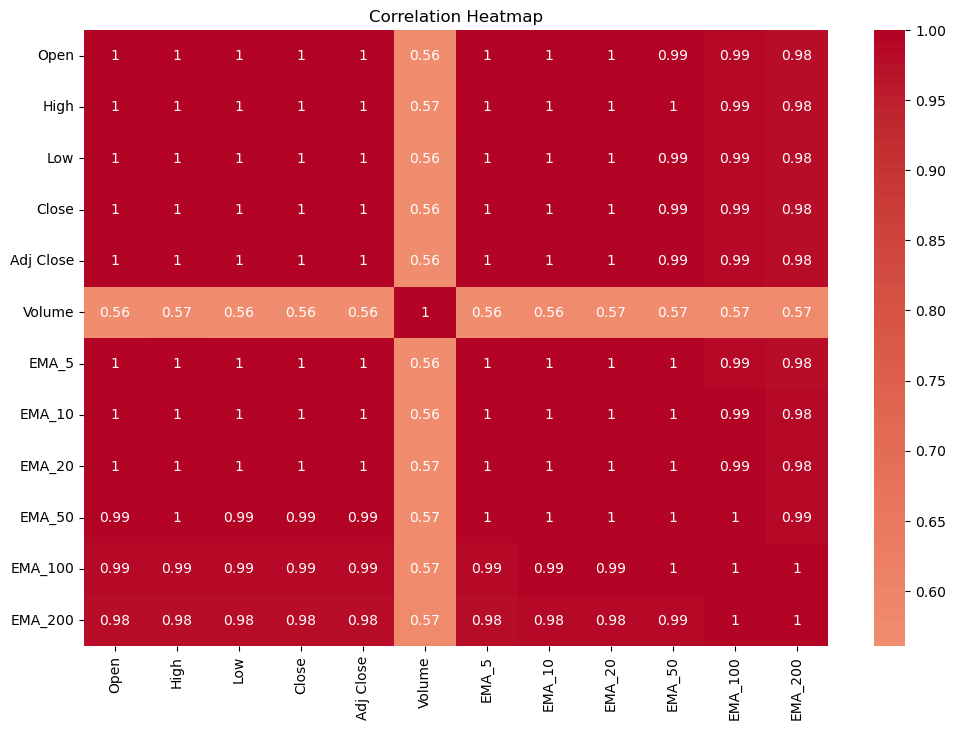

In [12]:
#Calculate correlation matrix
correlation_matrix = data.corr()

# Display correlation matrix as a heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.grid(False)
plt.show()


Conclusion

Above HeatMap Shows Columns of Whole Data are Highly Corelated Except Volume Column

In [13]:
X = data[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200']]
y = data['Close']

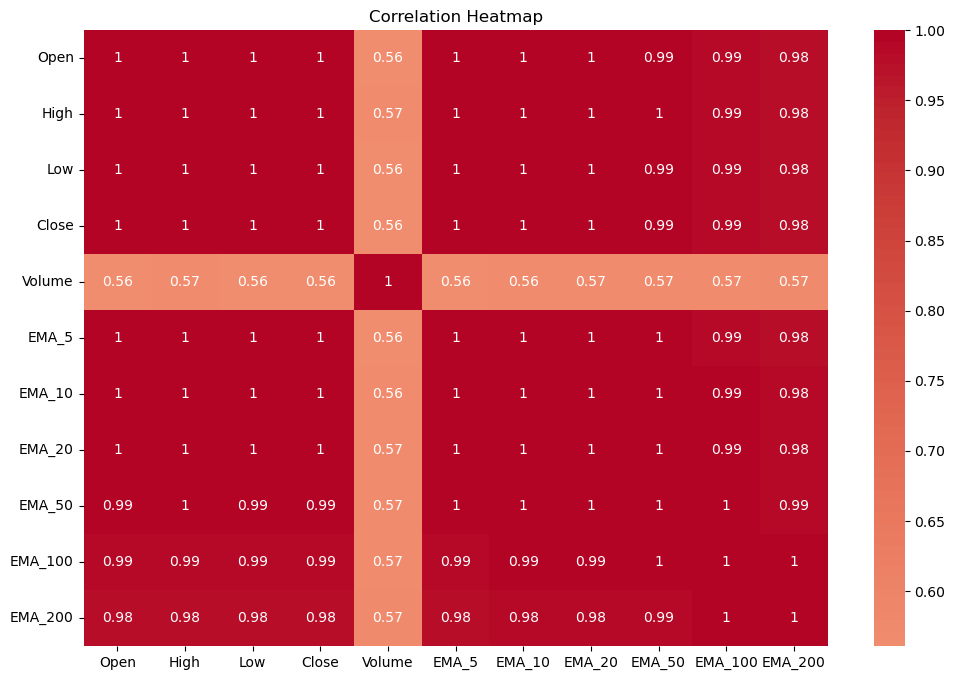

In [14]:
correlation_matrix = X.corr()

#  Display correlation matrix as a heatmap


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.grid(False)
plt.show()

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
#  Create pipelines for different regression models
pipelines = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor())
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor())
    ]),
    'Elastic Net': Pipeline([
        ('scaler', StandardScaler()),
        
        ('regressor', ElasticNet())
    ]),
}

Hyperparameter tuning is done for finding the best combination of hyperparameters to achieve optimal performance.
GridSearchCV systematically explores different hyperparameter combinations using cross-validation to find the best ones.

In [17]:
#  Perform hyperparameter tuning for Elastic Net
# alpha controls the overall strength of regularization, and l1_ratio controls the mix of L1 and L2 regularization.
param_grid = {
    'regressor__alpha': np.logspace(-3, 3, 7),
    'regressor__l1_ratio': np.linspace(0, 1, 11),
}

best_model = GridSearchCV(pipelines['Elastic Net'], param_grid, cv=5, scoring='r2')
best_model.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', ElasticNet())]),
             param_grid={'regressor__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'regressor__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='r2')

In [18]:
#  Evaluate models and calculate R2 scores and MSE
r2_scores = {}
mse_scores = {}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2_scores[name] = r2_score(y_test, y_pred)
    mse_scores[name] = np.mean((y_test - y_pred)**2)  # Calculate MSE

print("Evaluation Results:")
for name in pipelines.keys():
    print(f"{name}: R2 Score = {r2_scores[name]:.4f}, MSE = {mse_scores[name]:.4f}")
    print("*******************************************************************")

Evaluation Results:
Linear Regression: R2 Score = 1.0000, MSE = 0.0000
*******************************************************************
Random Forest: R2 Score = 1.0000, MSE = 268.0640
*******************************************************************
KNN: R2 Score = 0.9994, MSE = 11076.2991
*******************************************************************
Elastic Net: R2 Score = 0.9958, MSE = 82368.4301
*******************************************************************


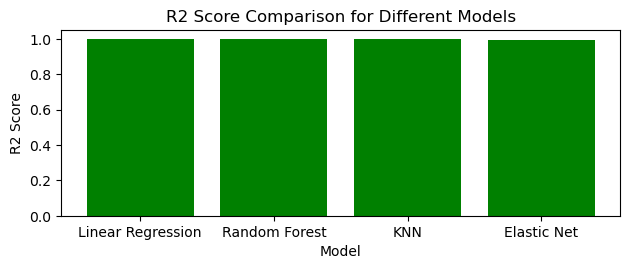

In [19]:
# Plot R2 scores for other models
plt.subplot(2, 1, 2)
plt.bar(r2_scores.keys(), r2_scores.values(), color='green')
#plt.bar(mse_scores.keys(), mse_scores.values(), color='b')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('R2 Score Comparison for Different Models')
plt.grid(False)
plt.tight_layout()
plt.show()



In [20]:
#  LSTM model
#This reshaping is necessary because LSTM models expect input in the shape of (samples, time steps, features)
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#adam is an optimizer adam=adaptive momentum
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_lstm, y_train, batch_size=20, epochs=100)


Epoch 1/100
149/149 [==============================] - 8s 12ms/step - loss: 104634720.0000
Epoch 2/100
149/149 [==============================] - 2s 12ms/step - loss: 101503080.0000
Epoch 3/100
149/149 [==============================] - 2s 13ms/step - loss: 96112920.0000
Epoch 4/100
149/149 [==============================] - 2s 12ms/step - loss: 88786168.0000
Epoch 5/100
149/149 [==============================] - 2s 11ms/step - loss: 80097488.0000
Epoch 6/100
149/149 [==============================] - 2s 11ms/step - loss: 70655376.0000
Epoch 7/100
149/149 [==============================] - 2s 11ms/step - loss: 61084224.0000
Epoch 8/100
149/149 [==============================] - 2s 11ms/step - loss: 51957012.0000
Epoch 9/100
149/149 [==============================] - 2s 11ms/step - loss: 43689492.0000
Epoch 10/100
149/149 [==============================] - 2s 11ms/step - loss: 36625032.0000
Epoch 11/100
149/149 [==============================] - 2s 12ms/step - loss: 30913222.0000
Epoch 

In [21]:
# Evaluate LSTM model
y_pred_lstm = model.predict(X_test_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print(f"LSTM R2 Score: {r2_lstm:.4f}")
print(f"LSTM Mean Squared Error: {mse_lstm:.4f}")

24/24 [==============================] - 1s 5ms/step
LSTM R2 Score: 0.4187
LSTM Mean Squared Error: 11379254.1219


In [22]:
# Choose a specific day for prediction
specific_day = '2022-12-01'  # Adjust this date based on available data
specific_day_data = data.loc[specific_day]


In [23]:
#  Predict the closing price for the specific day using each model
predicted_prices = {}
for name, pipeline in pipelines.items():
    predicted_price = pipeline.predict([specific_day_data[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200']]])
    predicted_prices[name] = predicted_price[0]

lstm_input = np.reshape(specific_day_data[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200']].values, (1, X.shape[1], 1))
lstm_predicted_price = model.predict(lstm_input)[0][0]
predicted_prices['LSTM'] = lstm_predicted_price

actual_price = specific_day_data['Close']


1/1 [==============================] - 0s 36ms/step


In [24]:
#  Print predicted and actual prices for the specific day
print(f"Actual Price on {specific_day}: {actual_price:.2f}")
print("Predicted Prices:")
for name, price in predicted_prices.items():
    print(f"{name}: {price:.2f}")

Actual Price on 2022-12-01: 18812.50
Predicted Prices:
Linear Regression: 18812.50
Random Forest: 18802.42
KNN: 18627.03
Elastic Net: 18037.70
LSTM: 11058.69


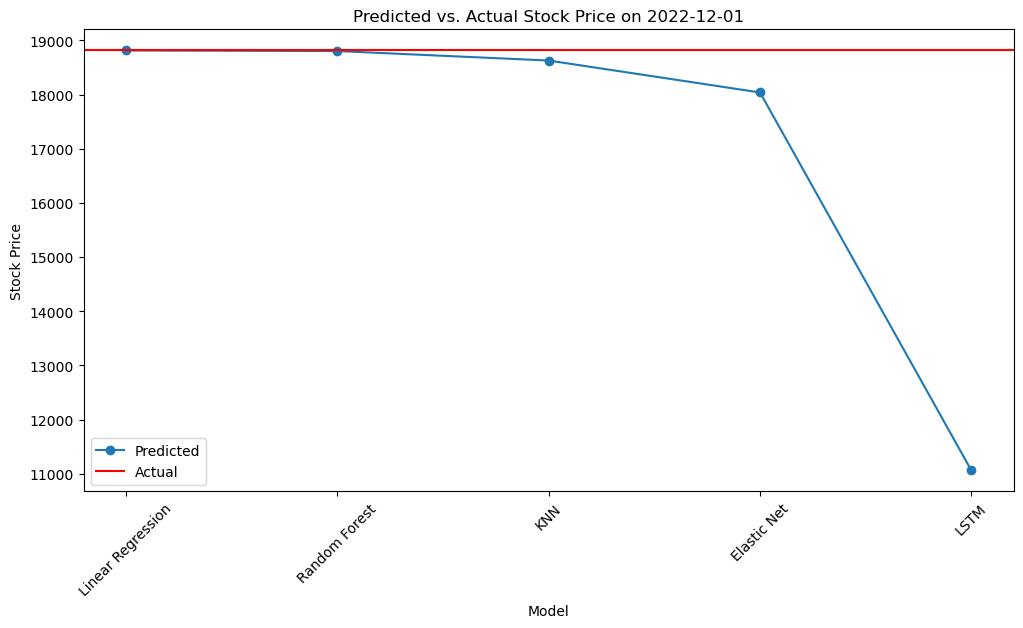

In [25]:
# Plot actual vs. predicted values for the specific day
plt.figure(figsize=(12, 6))
plt.plot(predicted_prices.keys(), predicted_prices.values(), marker='o', label='Predicted')
plt.axhline(y=actual_price, color='r', linestyle='-', label='Actual')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Stock Price')
plt.title(f'Predicted vs. Actual Stock Price on {specific_day}')
plt.legend()
plt.show()

In [26]:
#  Choose a specific day for prediction
future_date = '2023-08-29'  # Choose a future date beyond the available dataset
future_data = data.iloc[-1:].copy()  # Use the last available data point as a template
future_data.index = pd.to_datetime([future_date])  # Set the index to the chosen future date

#  Predict the closing price for the future date using each model
predicted_prices = {}
for name, pipeline in pipelines.items():
    # Preprocess data for the specific model
    model_X = pipeline.named_steps['scaler'].transform(future_data[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200']])
    future_prediction = pipeline.named_steps['regressor'].predict(model_X)
    predicted_prices[name] = future_prediction[0]

# LSTM model
lstm_input = np.reshape(future_data[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200']].values, (1, X.shape[1], 1))
lstm_future_prediction = model.predict(lstm_input)[0][0]
predicted_prices['LSTM'] = lstm_future_prediction



#  Print predicted prices for the future date
print(f"Predicted Prices for {future_date}:")
for name, price in predicted_prices.items():
    print(f"{name}: {price:.2f}")

1/1 [==============================] - 0s 34ms/step
Predicted Prices for 2023-08-29:
Linear Regression: 19265.80
Random Forest: 19304.41
KNN: 19392.01
Elastic Net: 18906.30
LSTM: 11058.69
